In [85]:
#Загрузим необходимые библиотеки
from collections import Counter
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
#Загрузим данные
df = pd.read_csv('Event_log.txt', sep='\t', encoding='cp1251')

In [47]:
#Предобработка данных
df['Event end'] = pd.to_datetime(df['Event end'])

#Предобработка данных: сортировка
order = ['Создание Заявки',
         'Заявка согласована',
         'Заявка изменена: дата доставки',
         'Заявка изменена: закупочная организация',
         'Заявка изменена: количество',
         'Заявка изменена: увеличена цена',
         'Заказ на поставку создан',
         'Требование авансового платежа',
         'Требование авансового платежа-Возврат',
         'Авансовый платеж',
         'Перерасчет по требованию авансового платежа',
         'Перерасчет авансового платежа',
         'Перерасчет авансового платежа-Возврат',
         'Заказ на поставку изменен: валюта',
         'Заказ на поставку изменен: налоговые условия',
         'Заказ на поставку изменен: срока предоставления скидки',
         'Заказ на поставку изменен: условия оплаты',
         'Заказ на поставку изменен: увеличено количество',
         'Заказ на поставку изменен: уменьшено количество',
         'Заказ на поставку изменен: увеличена цена',
         'Заказ на поставку изменен: уменьшена цена',
         'Заказ на поставку изменен: увеличена стоимость',
         'Заказ на поставку изменен: уменьшена стоимость',
         'Заказ на поставку изменен: эффективная стоимость',
         'Заказ на поставку изменен: группа закупки',
         'Заказ на поставку изменен: завод',
         'Заказ на поставку изменен: запланированный срок доставки в днях',
         'Заказ на поставку изменен: лимит на недопоставку',
         'Заказ на поставку изменен: лимит на сверх-поставку',
         'Заказ на поставку изменен: материал',
         'Заказ на поставку изменен: поставщик',
         'Заказ на поставку изменен: статус наличия счета',
         'Заказ на поставку изменен: тип документа',
         'Заказ на поставку согласован 1',
         'Заказ на поставку: изменен статус выпуска: ДанныеОтпр, возможны изменения',
         'Заказ на поставку: изменен статус выпуска: НачКод, возможны изменения',
         'Заказ на поставку: изменен статус выпуска: ДанныеСогл, измен не возможны',
         'Заказ на поставку: изменен статус выпуска: Согл, измен не возможны',
         'Заказ на поставку согласован 2',
         'Заказ на поставку: согласование отклонено',
         'Заявка: согласование отклонено',
         'Заказ на поставку бессрочно заблокирован',
         'Заказ на поставку удален',
         'Заявка удалена',
         'Заявка восстановлена',
         'Заказ на поставку восстановлен',
         'Поступление материала-Получение-Завершающая поставка',
         'Поступление материала-Получение-Частичная поставка',
         'Поступление материала-Возврат-Частичная поставка',
         'Поступление материала-Возврат-Завершающая поставка',
         'Счет предварительно полностью зарегистрирован',
         'Счет заведен',
         'Поступление счета',
         'Поступление счета-Возврат',
         'Счет блокирован: несоответствие даты',
         'Счет блокирован: несоответствие количества',
         'Счет блокирован: несоответствие цены',
         'Счет изменен: налоговые условия',
         'Счет изменен: условия оплаты',
         'Счет изменен: дата',
         'Платеж (выравнивание)',
         'Ведомость учета работ/услуг']
df['Activity'] = pd.Categorical(df['Activity'], categories=order)
df = df.sort_values(by=['Event end', 'Activity'])

In [48]:
# Данная функция - копия O_2(df) с различием в возвращаемых значениях, я использую ее вывод в других функциях,
# чтобы не портить O_2(df)
# eq_chains - события одного маршрута
# num_cases - CaseID цепочек, которые входят в маршрут
# d - словарь, в котором ключ - номер маршрута, значение - количество цеопчек этого маршрута 
# k - сколько всего маршрутов на текущий момент
# i - число для проверки того, прошли ли мы все значения словря за итерацию

def unique_paths(df):
    #Считает количество маршрутов.
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям. 
    #Выход: количество маршрутов.
    
    #Предобработка данных
    cases = df['CaseID'].unique()
    chain = df[df['CaseID'] == cases[0]]
    activ = chain['Activity'].tolist()
    
    #Подготовим необходимые массивы
    eq_chains = []
    num_cases = [[] for i in range(len(cases))]
    
    #Выполним первую инициализацию
    eq_chains.append(activ)
    num_cases[0].append(cases[0])
    d = {}
    d[0] = 1
    k = 1
    
    #Запустим цикл, выполняя то же самое
    for case in cases[1:]:
        #Пердобработка данных.
        chain = df[df['CaseID'] == case]
        activ = chain['Activity'].tolist()
        i = 0
        
        #Проверка на наличие такого пути
        for key in d.keys():
            if eq_chains[key] == activ:
                d[key] += 1
                num_cases[key].append(case)
                break
            i += 1
        if i == k:
            d[k] = 1
            eq_chains.append(activ)
            num_cases[k].append(case)
            k += 1
    return d, eq_chains, num_cases

## KPI

На вход подается объект - dataframe.

### Общие.

1) О-1 Общее количество экземпляров процесса (кейсов). +

2) О-2 Количество маршрутов. +

3) О-3 Количество уникальных пользователей. +

4) О-4 Число начатых и завершившихся экземпляров процесса. +


5) О-5 Нестандартные по времени экземпляры процесса. +

6) О-6 Сложные экземпляры процесса. (на доработке)

7) О-7 Среднее количество циклов на экземпляр процесса.+


8) О-8 Среднее количество экземпляров процесса, созданных за один день. +

9) О-9 Самые популярные категории событий. +


10) О-10 Среднее количество времени, проведенное в рамках одного класса событий. +


#### 1. О-1 Общее количество экземпляров процесса (кейсов).

In [49]:
def O_1(df):
    #Вычисляет общее количество экземпляров процесса .
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям.
    #Выход: общее количество цепочек.
    
    #Подсчет количества экземпляров процесса
    return len(df['CaseID'].unique())

In [50]:
#time check
%time O_1(df)

CPU times: user 8.06 ms, sys: 912 µs, total: 8.97 ms
Wall time: 9.36 ms


8025

#### 2. О-2 Количество маршрутов.

In [51]:
def O_2(df):
    #Считает количество маршрутов.
    #Вход:  dataframe - eventlog, отсортированный по временной отметке и событиям. 
    #Выход: количество маршрутов.
    
    #Предобработка данных
    cases = df['CaseID'].unique()
    chain = df[df['CaseID'] == cases[0]]
    activ = chain['Activity'].tolist()
    
    #Подготовим необходимые массивы
    eq_chains = []
    num_cases = [[] for i in range(len(cases))]
    
    #Выполним первую инициализацию
    eq_chains.append(activ)
    num_cases[0].append(cases[0])
    d = {}
    d[0] = 1
    k = 1
    
    #Запустим цикл по оставшимся кейсам
    for case in cases[1:]:
        #Пердобработка данных.
        chain = df[df['CaseID'] == case]
        activ = chain['Activity'].tolist()
        i = 0
        
        #Проверка на наличие такого пути
        for key in d.keys():
            if eq_chains[key] == activ:
                d[key] += 1
                num_cases[key].append(case)
                break
            i += 1
            
        #Добавление нового пути
        if i == k:
            d[k] = 1
            eq_chains.append(activ)
            num_cases[k].append(case)
            k += 1
    return len(d)

In [52]:
%time O_2(df)

CPU times: user 57.7 s, sys: 670 ms, total: 58.4 s
Wall time: 59.2 s


1653

#### 3. О-3 Количество уникальных пользователей.

In [53]:
def O_3(df):
    #Вход:  dataframe - eventlog.
    #Выход: количество уникальных пользователей.
    
    #Подсчет количества уникальных пользователей
    return len(df['User'].dropna().unique())

In [54]:
#time check
%time O_3(df)

CPU times: user 16.2 ms, sys: 2.48 ms, total: 18.7 ms
Wall time: 18.9 ms


123

#### 4. О-4 Число начатых и завершившихся экземпляров процесса (кейсов)..

In [55]:
def O_4(df):
    #Считает число начатых и законченных экземпляров процесса (кейсов) и их долю от общего числа экземпляров процесса.
    #Вход:  dataframe - eventlog.
    #Выход: число и отношение кол-ва начатых и завершенных экземпляров процесса (кейсов)
    #       (т.е. таких экземпляров процесса (кейсов), которые закончились Катагорией События
    #       ('Activity Category') == 'Платеж (выравнивание)') к общему кол-ву экземпляров процесса.
    
    #Поиск кейсов с 'Activity Category' равным 'Заказ на поставку создан' и 'Платеж (выравнивание)'
    started_cases = set(df.iloc[np.where(df['Activity Category'] == 'Заказ на поставку создан')]['CaseID'])
    finished_cases = set(df.iloc[np.where(df['Activity Category'] == 'Платеж (выравнивание)')]['CaseID'])
    
    #Подсчет мощности пересечения найденных множеств и доли среди всех кейсов
    return len(started_cases & finished_cases), len(started_cases & finished_cases) / len(df['CaseID'].unique())

In [56]:
#time check
%time O_4(df)

CPU times: user 49 ms, sys: 4.96 ms, total: 54 ms
Wall time: 53 ms


(7313, 0.9112772585669782)

#### 5. О-5 Нестандратные по времени экземпляры процесса (кейсы).

In [69]:
def O_5(df):
    # Вычисляет нестандартные экземпляры процесса (кейсы) по времени.
    # Нестандартная экземпляр процесса - экземпляр процесса, который отклоняется по времени от среднего
    # более чем на два стандартных отклонения.
    # Вход:  dataframe-eventlog.
    # Выход: кортеж(tuple). 
    #        Первое значение - количество нестандартных по времени экземпляров процесса.
    #        Второе значение - процентное соотношение этих экземпляров процесса ко всем экземплярам процесса.
    
    #Сбор всех цепочек
    cases = df['CaseID'].unique()
    
    #Рассчет времени прохождения экземпляры процесса
    all_time = df.groupby(
        ['CaseID'])['Event end'].apply(
        lambda a: (a.max() - a.min()).total_seconds()
    )
    
    #Учет в рамках маршрутов
    d, eq_chains, num_cases = unique_paths(df)
    ind = 0
    anomal_cases = []
    
    #Подсчет необходимых метрик в рамках маршрута
    for i in range(len(num_cases)): 
        c = num_cases[i]
        av = np.mean(all_time[c])
        std = np.std(all_time[c])
        to_remember = np.where(all_time[c] > av + 2 * std)[0]
        if len(to_remember) != 0:
            anomal_cases.append(num_cases[i])
        ind += len(to_remember)
    return ind, ind / len(cases)

In [70]:
#time check
%time O_5(df)

CPU times: user 1min 18s, sys: 786 ms, total: 1min 18s
Wall time: 1min 20s


(235, 0.029283489096573207)

#### 6. О-6 Сложные экземпляры процесса.

In [71]:
def convert_to_adj_list(activ):
    #Переводит из последовательности событий в список смежности.(более удобное представление графа).
    #Вход:  activ - list, массив строк - последовательность событий одного экземпляра процесса.
    #Выход: res - list, массив смежности графа.
    
    #Подготовка массивов
    decode = list(set(activ))
    dec_dict = {}
    res = [[] for i in range(len(decode))]

    #Подготовка значений
    for i in range(len(decode)):
        dec_dict[decode[i]] = i

    #Перевод значений из из цепочки в граф
    for i in range(len(activ) - 1):
        res[dec_dict[activ[i]]].append(dec_dict[activ[i + 1]])

    return res

def O_6(df):
    #Считает количество сложных экземплярлв процесса. Сложный экземпляр процесса - такой экземпляра процесса, 
    #который отклоняется от среднего больше, чем на одно стандартное отклонение,
    #по количеству событий и количеству циклов. 
    #Вход:  dataframe-eventlog.
    #Выход: количество сложных экземпляров процесса.
    
    #Подготовка значений
    num_of_loop_in_case = {}
    cases = df['CaseID'].unique()
    begin = time.time()

    #Группировка по кейсам
    num_of_act_in_case = df.groupby('CaseID').agg({'Activity': 'count'})['Activity'].to_dict()

    #Запуск цикла по кейсам
    for case in cases:
        
        #Сбор кейса по активити
        chain = df.iloc[np.where(df['CaseID'] == case)]
        activ = chain['Activity'].tolist()
        
        #Создание вспомогательной переменной
        l_am = 0
        if len(activ) != len(set(activ)):

            #Вызов функции перевода в граф смежности
            conv_activ = convert_to_adj_list(activ)
            
            #Создание вспомогательного массива
            visited = [0 for i in range(len(conv_activ))]
        
            def dfs(vert, l_am):
                #Обход в глубину.
                #Вход:  массив вершин и количество циклов
                #Выход: количество циклов
                visited[vert] = 1
                for v in conv_activ[vert]:
                    if not visited[v]:
                        l_am = dfs(v, l_am)
                    else:
                        l_am += 1
                return l_am
            
            #Подсчет количества циклов для кейса
            for i in range(len(conv_activ)):
                if not visited[i]:
                    l_am += dfs(i, l_am)
        num_of_loop_in_case[case] = l_am
    
    #Подготовка необходимых массивов
    loop_in_case = np.array(list(num_of_loop_in_case.values()))
    act_in_case = np.array(list(num_of_act_in_case.values()))
    
    #Подсчет необходимых метрик
    av_loop = np.mean(loop_in_case)
    std_loop = np.std(loop_in_case) 
    ind_loop = np.where(loop_in_case > av_loop + std_loop)
    av_act = np.mean(act_in_case)
    std_act = np.std(act_in_case)
    ind_act = np.where(act_in_case > av_act + std_act)
    return len(set(ind_act[0]) & set(ind_loop[0]))

In [72]:
#time check
%time O_6(df)

CPU times: user 58.1 s, sys: 641 ms, total: 58.8 s
Wall time: 59.6 s


3

#### 7. О-7 Среднее количество циклов на один экземпляр процесса.

In [100]:
def O_7(df):    
    #Вычисляет среднее количество циклов на один экземпляр процесса.
    #Вход:  dataframe - eventlog.
    #Выход: среднее количество циклов на один экземпляр процесса.
    
    #Подготовка значений
    n_df = df.drop(df[df['Activity'] == 'Платеж (выравнивание)'].index)
    cases = n_df['CaseID'].unique()    
    loops = []
    ind = {}
    i = 0
    
    #Запуск цикла по всем кейсам
    for case in cases:
        
        #Подготовка значений
        chain = n_df[n_df['CaseID'] == case]
        activ = chain['Activity'].tolist()
        ind[case] = i
        events = set()
        loop_am = 0
        
        #Проверка наличия цикла
        for act in activ:
            if act in events:
                loop_am += 1
            events.add(act)
        i += 1        
        loops.append(loop_am)
        
    #Подсчет по каждому маршруту
    d, eq_chains, num_cases = unique_paths(n_df)
    av = []
    loops = np.array(loops)
    for c in num_cases: 
        summ = 0
        count = 0
        for j in c:
            summ += ind[j]
            count += 1
        if count:
            av.append(summ / count)
        else:
            av.append(0)
    return np.array(av).mean()

In [101]:
#time check
%time O_7(df)

CPU times: user 1min 43s, sys: 1.02 s, total: 1min 44s
Wall time: 1min 45s


1044.6829741055237

#### 8. О-8 Среднее количество экземпляров процесса (кейсов), созданных за один день.

In [90]:
def O_8(df):
    #Вычисляет среднее количество экземпляров процесса, созданных за день.
    #(т.е. таких, у которых Событие('Activity') == 'Заказ на поставку создан')
    #Вход:  dataframe - eventlog.
    #Выход: среднее количество экземпляров процесса, созданных за день.
    
    #Подготовка данных
    df_n = pd.DataFrame(df, columns=['Event end', 'CaseID', 'Activity'])
    df_n['Event end'] = df_n['Event end'].astype(str).apply(lambda x: x[:10])
    count = df_n.iloc[np.where(df_n['Activity'] == 'Заказ на поставку создан')]['Event end']
    
    #Подсчет количества кейсов по дням
    am = sum(Counter(df_n.iloc[np.where(df_n['Activity'] == 'Заказ на поставку создан')]['Event end']).values())
    
    #Подсчет общего числа дней
    days = len(df_n['Event end'].unique())
    
    #Вывод гистограммы
    plt.figure(figsize=(25, 10))
    plt.title('Распределние создания экземпляров процесса по неделям')
    plt.xlabel('Дата')
    plt.ylabel('Количество созданий')
    plt.hist(pd.to_datetime(count.values), bins=52, alpha=0.78)
    plt.show()
    
    #Полсчет среднего числа
    return am / days

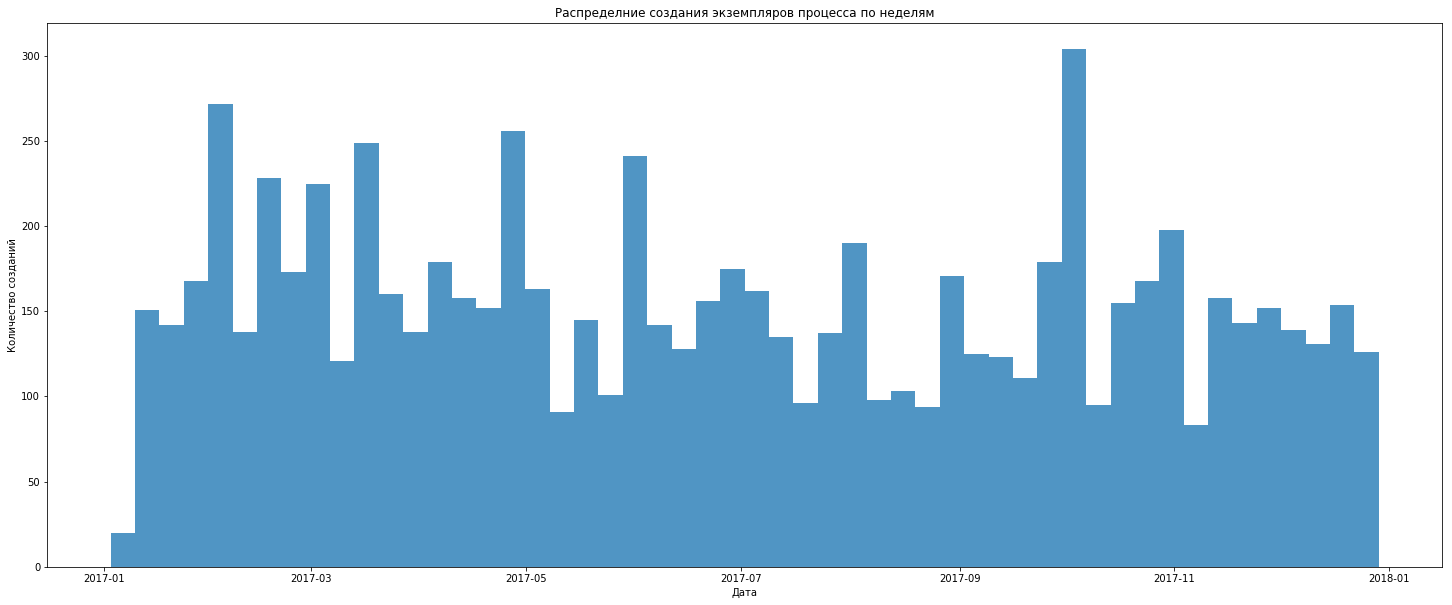

CPU times: user 1.73 s, sys: 208 ms, total: 1.94 s
Wall time: 1.48 s


28.57857142857143

In [91]:
#time check
%time O_8(df)

#### 9. О-9 Самые популярные категории событий.

In [94]:
def O_9(df):
    #Вычисляет популярные категории событий относительно количества экземпляров процесса и пользователей.
    
    #Вход:  dataframe - eventlog.
    #Выход: Кортеж (act_am_dict, users_am_dict) 
    #        act_am_dict - словарь, в котором ключ - название категории событий('Activity Category'),
    #        а значение - отношение количества событий, входящих в эту категорию, и количества всех событий.
    #        users_am_dict - словарь, в котором ключ - название категории событий('Activity Category'),
    #        а значение - количество уникальных пользователей, которые участвовали в этой категории событий.
    
    #Подготовка значений
    df_n = df.drop(df[df['Activity Category'] == 'Платеж (выравнивание)'].index)
    act_am_dict = df_n.groupby('Activity Category')['CaseID'].unique().apply(lambda x: len(x))\
                  .div(len(df_n['CaseID'].unique())).to_dict()
    users_am_dict = df_n.groupby('Activity Category').agg({"User": lambda x: x.nunique()}).to_dict()['User']
    
    #Сортировка
    sorted_act_am_dict = sorted(act_am_dict.items(), key=lambda kv: kv[1], reverse=True)
    sorted_users_am_dict = sorted(users_am_dict.items(), key=lambda kv: kv[1], reverse=True)

    return sorted_act_am_dict[:5], sorted_users_am_dict[:5]

In [95]:
#time check
%time O_9(df)

CPU times: user 94.9 ms, sys: 14.5 ms, total: 109 ms
Wall time: 110 ms


([('Заказ на поставку создан', 0.9971339563862929),
  ('Поступление счета', 0.9384423676012461),
  ('Статус счета изменен', 0.9330841121495327),
  ('Счет изменен', 0.7774454828660436),
  ('Поступление материала-Получение', 0.4777570093457944)],
 [('Заказ на поставку создан', 87),
  ('Заказ на поставку изменен', 55),
  ('Поступление материала-Получение', 36),
  ('Поступление материала-Возврат', 26),
  ('Заказ на поставку согласован', 19)])

#### 10. О-10 Среднее количество времени, проведенное в рамках одного класса событий.

In [98]:
def convert_time(time):
    #Функция перевода времени
    #Вход:  время числом в секундах
    #Вывод: Сформированная строка по дням, часам, минутам и секундам
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    
    return "%d Days %d Hours %d Minutes %d Seconds" % (day, hour, minutes, seconds)

def O_10(df):
    #Вычисляет отношение общего времени, проведенного в рамках категории события, к количеству экземпляров процесса,
    #которые были охвачены этой категорией события.
    #Вход:  dataframe - eventlog,  отсортированный по временной отметке и событиям.
    #Выход: all_time - словарь, где ключ - название категории события, а значение - среднее количество проведенного 
    #       времени в рамках соотв. категории события на экземпляр события.
    
    #Подготовка необходимых значений
    df.sort_values(by='Event end', inplace=True)
    all_time = {cat : 0 for cat in df['Activity Class'].unique()}
    case_am = {cat : 0 for cat in df['Activity Class'].unique()}
    cases = df['CaseID'].unique()
    
    #Запускаем цикл по всем кейсам
    for case in cases:
        
        #Подготовка необходимых значений
        chain = df.iloc[np.where(df['CaseID'] == case)]
        cat = chain['Activity Class'].tolist()
        time = chain['Event end'].tolist()
        
        #Подсчет времени для каждого класса кейса
        for i in range(len(cat) - 2):
            all_time[cat[i]] += (time[i + 1] - time[i]).total_seconds()
        
        #Подсчет количества кейсов, у которых были классы
        for cl in cat:
            case_am[cl] += 1
    return case_am

In [99]:
#time check
%time O_10(df)

CPU times: user 1min 2s, sys: 627 ms, total: 1min 2s
Wall time: 1min 3s


{'Авансовый платеж': 1293,
 'Заказ на поставку': 22909,
 'Заявка': 6310,
 'Платеж (выравнивание)': 12625,
 'Поступление материала': 8848,
 'Счет': 32897,
 'Учет услуг': 3356}